# Text Detection Network

The goal of this notebook is to build, train and test a **deep network** for **text detection**. The input of the network is a color image containing text and the output are **bounding boxes** indicating the **location** of text inside images.

![text_detection](./imgs/detection.png)

The training and test of the network is done using a **synthetic text dataset** containing random words over diverse and challenging backgrounds. 

**Requirements:**
This notebook requires the following libraries:
+ Numpy
+ Tensorflow [GPU]
+ Matplotlib
+ PIL

**Michael Villamizar** <br>
mvillamizar@idiap.ch <br>
Idiap Research Institute <br>
Switzerland - 2017 <br>


In [10]:
# Libraries.
import os
import sys
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

# Additional libraries.
import evaluation as eval  # Code for text detection evaluation.

### Synthetic Text Dataset (STD)

The synthetic text dataset contains color images of **112x112** pixels with **random words** over diverse backgrounds. **Single** words appear at different locations, fonts, sizes and colors in order to increase the difficulty of the problem. Some example images are shown below:

![dataset examples](./imgs/examples.png)

Each image has associated an **annotation mask** -ground truth- indicating the location of the word using a bounding box. For the current dataset, the annotation mask is a **feature grid** of 14x14 cells and **5 features** depth. Each cell has size of 8x8 pixels. The first feature corresponds to the **confidence** that indicates the presence of text in any cell. For example, if the center of the word falls inside *cell_i*, the confidence *c_i* is set to 1. Otherwise, *c_i* is 0. The rest features correspond to the **coordinates** of the bounding box (x, y, width, height) relative to the center of the cell.
This is illustrated in the following figure. 

![dataset_annotation](./imgs/dataset_annotation.png)

TSD comprises three different sets: **training**, **validation** and **test** sets. The former is used to compute the network whereas the validation set is used to tune the network parameters. The test set is used for evaluation **only**.

In [11]:
# Load dataset.
dataset = pickle.load(open('./data/dataset.p','rb'))

# Extract images and convert the images from uint8 to float.
train_images = dataset['train_images'].astype(np.float)
valid_images = dataset['valid_images'].astype(np.float)
test_images = dataset['test_images'].astype(np.float)

# Extract ground truth -annotation masks-.
train_masks = dataset['train_labels']
valid_masks = dataset['valid_labels']
test_masks = dataset['test_labels']

# Dataset values.
num_train_imgs = dataset['info']['num_train_images']
num_valid_imgs = dataset['info']['num_valid_images']
num_test_imgs = dataset['info']['num_test_images']
cell_size = dataset['info']['cell_size']
input_size = dataset['info']['image_size']  # Image size.
output_size = dataset['info']['grid_size']  # Feature grid size.
input_depth = 3  # Color input images -RGB-.
output_depth = 5  # Network output depth [confidence, x, y, w, h].

# Print dataset information.
print('Synthetic text dataset:')
print('+ Num. train images: {0}'.format(num_train_imgs))
print('+ Num. validation images: {0}'.format(num_valid_imgs))
print('+ Num. test images: {0}'.format(num_test_imgs))
print('+ Input size: {0}'.format(input_size))
print('+ Input depth: {0}'.format(input_depth))
print('+ Output size: {0}'.format(output_size))
print('+ Output depth: {0}'.format(output_depth))
print('+ Cell size: {0}'.format(cell_size))

# Delete dataset variable.
del dataset

Synthetic text dataset:
+ Num. train images: 4000
+ Num. validation images: 500
+ Num. test images: 500
+ Input size: (112, 112)
+ Input depth: 3
+ Output size: (14, 14)
+ Output depth: 5
+ Cell size: (8, 8)


### Examples

Next some example images used for training are shown.
Each image contains random background and artificial text.

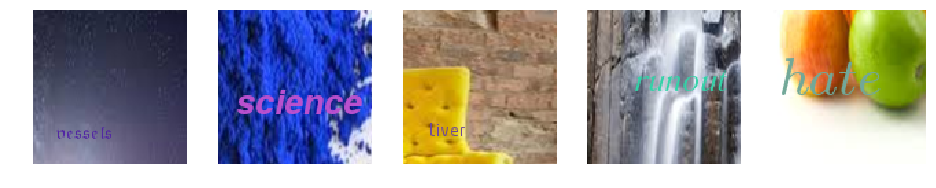

In [12]:
# Show example images chosen at random.
def fun_show_examples(images, num_examples=10):
    # Number of images.
    num_imgs = np.shape(images)[0]
    # Figure.
    fig = plt.figure(figsize=(16,10))
    for i in range(num_examples):
        # Random image index.
        rnd_ind = int(np.random.random()*num_imgs)
        # Random image.
        rnd_img = images[rnd_ind,:,:,:]
        # Show image.
        ax = fig.add_subplot(1, num_examples, i+1)
        ax.imshow(np.uint8(rnd_img))
        ax.axis('off')
    plt.show()

# Show example images.
fun_show_examples(train_images, num_examples=5)

### Normalize Images

All images are normalized to have pixel values in the range [-0.5, 0.5]. The images are initially integers between 0 and 255.

In [13]:
# Normalize images.
def fun_normalize(images):
    return images/255.0 - 0.5

# Normalize training, validation and test images.
train_images = fun_normalize(train_images)
valid_images = fun_normalize(valid_images)
test_images = fun_normalize(test_images)

### Network Computation

The following scheme shows the **default** network used for text detection. This network is a **fully** convolutional network including 4 **convolutional** layers and 3 **max-pooling** layers. The last layer is a **linear** layer to return the confidence and the coordinates of the bounding box. All convolutional filters have a size of 3x3.

![network](./imgs/network.png)

***Note:*** The number of max-pooling layers must be 3 in order to get the feature grid size (14x14 cells).


### Network Functions

Below are defined the functions to compute, train and evaluate the deep network.

In [14]:
# GPU configuration.
def fun_gpu_configuration():
    ''' This function sets up the GPU configuration. '''

    # Config for gpu memory.
    config = tf.ConfigProto()
    config.log_device_placement = False
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = "BFC"
   
    return config

# Placeholders
def fun_placeholders(batch_size):
    ''' This function defines the placeholders for network computation. '''

    # Placeholder for images -batch of images-.
    x_image = tf.placeholder(tf.float32, [batch_size, input_size[0], \
                                          input_size[1], input_depth], \
                                          name='x_image')
    # Placeholder for annotation masks -batch of masks-.
    y_mask = tf.placeholder(tf.float32, [batch_size, output_size[0], \
                                         output_size[1], output_depth], \
                                         name='y_mask')
    # Placeholder for dropout factor.
    keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')

    # Placeholder for batch normalization. This indicates if the network is 
    # during training phase.
    train_phase = tf.placeholder(tf.bool, [], name='train_phase')

    return x_image, y_mask, keep_prob, train_phase

# Convolutional layer.
def fun_conv_layer(input, name='conv', size_in=20, size_out=20, \
                   filter_width=3, filter_height=3, padding='SAME'):
    ''' This function computes a convolutional layer. '''

    with tf.name_scope(name):
        # Variables: weights and bias.
        w = tf.Variable(tf.truncated_normal([filter_height, filter_width, \
                         size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.0, shape=[size_out]), name="B")

        # Operations: convolution and relu activation function.
        c = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding=padding)
        a = tf.nn.relu(tf.nn.bias_add(c, b))
        
    return a

# Convolutional layer + batch normalization.
def fun_conv_bn_layer(input, name='conv', size_in=20, size_out=20, \
                   filter_width=3, filter_height=3, train_phase=False, \
                   padding='SAME'):
    ''' This function computes a convolutional layer using batch 
    normalization. '''
   
    with tf.name_scope(name):
        # Variables: weights and bias.
        w = tf.Variable(tf.truncated_normal([filter_height, filter_width, \
                         size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.0, shape=[size_out]), name="B")

        # Operations: convolution.
        c = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding=padding)
        d = tf.nn.bias_add(c, b)
        
        # Batch normalization.
        bn = tf.contrib.layers.batch_norm(d, is_training=train_phase, \
                                          center=True, scale=True, \
                                          updates_collections=None, \
                                          decay=0.9, scope=name)
        # Operation: relu.
        a = tf.nn.relu(bn)

        #****************************************************
        # Exercise 5: Leaky Relu function.
        # Please change the activation function in line "a".
        # Comment that line and uncomment the below one to use
        # the Relu function.
        #****************************************************
        #alpha = 0.01  # Factor.
        #a = tf.maximum(bn, alpha * bn)  # Leaky function.
        
    return a

# Linear layer.
def fun_linear_layer(input, name='linear', size_in=20, size_out=20, \
                     filter_size=3, padding='SAME'):
    ''' This function computes a linear layer. '''

    with tf.name_scope(name):
        # Variables: weights and bias.
        w = tf.Variable(tf.truncated_normal([filter_size, filter_size, \
                         size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.0, shape=[size_out]), name="B")

        # Operations: convolution.
        c = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding=padding)
        a = tf.nn.bias_add(c, b)

    return a

# Max pooling layer.
def fun_max_pool(input, name='pool'):
    ''' This function computes a max-pooling layer (2x2). '''

    with tf.name_scope(name):
        # Operation: max pooling.
        a = tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], \
                           padding='SAME')
    return a

# Network.
def fun_network(input, keep_prob, train_phase):
    ''' This function defines the structure of the deep network for text 
    detection.'''

    #****************************************************
    # Exercise 1: Number of feature maps.
    # Please change the number of feature maps in all layers.
    # Change from 16 to 32 feature maps. Train and test again.
    #***************************************************
 
    # Parameters.
    depth_1 = 16  # Number of feature maps -layer 1-.
    depth_2 = 16  # Number of feature maps -layer 2-.
    depth_3 = 16  # Number of feature maps -layer 3-.
    depth_4 = 16  # Number of feature maps -layer 4-.
    
    # Operations.
    a1 = fun_conv_layer(input, 'C1', input_depth, depth_1, 3, 3)
    p1 = fun_max_pool(a1, 'P1')
    a2 = fun_conv_layer(p1, 'C2', depth_1, depth_2, 3, 3)
    p2 = fun_max_pool(a2, 'P2')
    a3 = fun_conv_layer(p2, 'C3', depth_2, depth_3, 3, 3)
    p3 = fun_max_pool(a3, 'P3')
    a4 = fun_conv_layer(p3, 'C4', depth_3, depth_4, 3, 3)
    out = fun_linear_layer(a4, 'L1', depth_4, output_depth) # Line 'ex2'
 
    #****************************************************
    # Exercise 2: Network depth
    # Add two extra convolutional layers. Please comment
    # the above line 'ex2' and uncommnent the following ones.
    # Train and test the network. Check the performance of 
    # the network for text detection.
    #****************************************************
    #depth_5 = 32  # Number of feature maps -layer 5-.
    #depth_6 = 32  # Number of feature maps -layer 6-.
    #a5 = fun_conv_layer(a4, 'C5', depth_4, depth_5, 3, 3)
    #a6 = fun_conv_layer(a5, 'C6', depth_5, depth_6, 3, 3)
    #out = fun_linear_layer(a6, 'L1', depth_6, output_depth)
  
    #****************************************************
    # Execise 3: Batch normalization.
    # Please, change all the default convolutional layers 
    # (fun_conv_layer) by convolutional layers including 
    # batch normalization (fun_conv_bn_layer).
    # Example:
    # <= a1 = fun_conv_layer(input, 'C1', input_depth, depth_1, 3, 3)
    # => a1 = fun_conv_bn_layer(input, 'C1', input_depth, depth_1, 3, 3, train_phase)
    # Note: train phase if a flag used in batch normalization
    # to indicate that the network is under training or not.
    #****************************************************
 
    #****************************************************
    # Execise 4: Rectangular filters.
    # Please, change the size of the convolutional filters
    # in the last two layers, from 3x3 to 7x3 (rectangular 
    # filters). This improves the detection of words.
    # Example:
    # <= a5 = fun_conv_bn_layer(a4, 'C5', depth_4, depth_5, 3, 3, train_phase)
    # => a5 = fun_conv_bn_layer(a4, 'C5', depth_4, depth_5, 7, 3, train_phase)
    #****************************************************
 
    return out

# Mean squared error loss.
def fun_mean_squared_error_loss(prediction, y_mask, batch_size):
    # This function computes the loss using the mean-squared-error. '''

    # Weights.
    w1 = 5  # Weights for box coordinates estimation.
    w2 = 9  # Weights for detection confidences.

    # Loss weights computation.
    y_slice = tf.slice(y_mask, [0, 0, 0, 0], [batch_size, output_size[0], \
                                             output_size[1], 1], 'y_slice')
    # Adding weights.
    y_slice_b = y_slice*w1
    y_slice_a = y_slice*w2 + 1
    weights = tf.concat([y_slice_a, y_slice_b, y_slice_b, y_slice_b, \
                         y_slice_b], 3)
    # Weighted loss.
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.multiply(tf.squared_difference(prediction, \
                                                            y_mask),weights))
    return loss

# Optimizer.
def fun_optimizer(loss):
    ''' This function computes the optimizer. '''

    # Optimizer.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer().minimize(loss)

    return optimizer

# Next mini batch.
def fun_next_batch(images, masks, batch_size, iteration, shuffle=True):
    ''' This function provides a mini-batch of images and annotation masks. '''
    
    # Number of images.
    num_imgs = np.shape(images)[0]

    # Suffle image and masks.
    if shuffle==True:
        
        # Random indexes.
        indxs = np.arange(num_imgs)
        np.random.shuffle(indxs)
        
        # Batch.
        indxs = indxs[:batch_size]
        y_masks = masks[indxs, :, :, :]
        x_images = images[indxs, :, :, :]
        
    # Sorted batch.
    if shuffle==False:
        
        # Indexes according to the input iteration.
        index_1 = (iteration*batch_size) % num_imgs
        index_2 = (iteration*batch_size + batch_size) % num_imgs

        # Batch.
        if index_2 > index_1:
            y_masks = masks[index_1:index_2, :, :, :]
            x_images = images[index_1:index_2, :, :, :]
        else:
            y_masks_1 = masks[index_1:, :, :, :]
            x_images_1 = images[index_1:, :, :, :]
            y_masks_2 = masks[:index_2, :, :, :]
            x_images_2 = images[:index_2, :, :, :]
            y_masks = np.vstack((y_masks_1, y_masks_2))
            x_images = np.vstack((x_images_1, x_images_2))
        
    return x_images, y_masks

### Train/Test

Following, the network is trained and evaluated used the synthetic text dataset.

Training:
  [Step] [Train|Validation loss] [Train|Validation F-score]
  [Step: 50/1500] [Loss: 0.027|0.040] [F-score: 0.000|0.000] 
  [Step: 100/1500] [Loss: 0.034|0.032] [F-score: 0.000|0.000] 
  [Step: 150/1500] [Loss: 0.036|0.045] [F-score: 0.000|0.000] 
  [Step: 200/1500] [Loss: 0.039|0.049] [F-score: 0.000|0.000] 
  [Step: 250/1500] [Loss: 0.019|0.041] [F-score: 0.000|0.000] 
  [Step: 300/1500] [Loss: 0.053|0.027] [F-score: 0.000|0.000] 
  [Step: 350/1500] [Loss: 0.036|0.042] [F-score: 0.000|0.182] 
  [Step: 400/1500] [Loss: 0.032|0.044] [F-score: 0.182|0.000] 
  [Step: 450/1500] [Loss: 0.023|0.028] [F-score: 0.333|0.182] 
  [Step: 500/1500] [Loss: 0.027|0.035] [F-score: 0.154|0.167] 
  [Step: 550/1500] [Loss: 0.048|0.038] [F-score: 0.000|0.000] 
  [Step: 600/1500] [Loss: 0.040|0.022] [F-score: 0.167|0.167] 
  [Step: 650/1500] [Loss: 0.026|0.021] [F-score: 0.000|0.267] 
  [Step: 700/1500] [Loss: 0.026|0.027] [F-score: 0.000|0.000] 
  [Step: 750/1500] [Loss: 0.023|0.024] [F-score: 

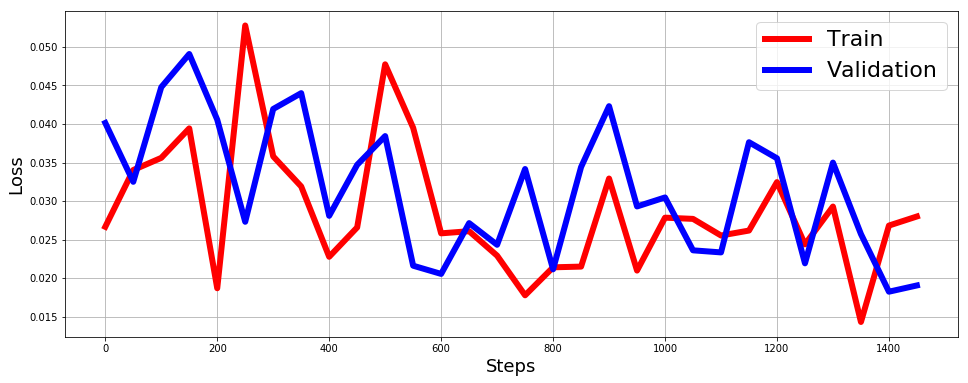

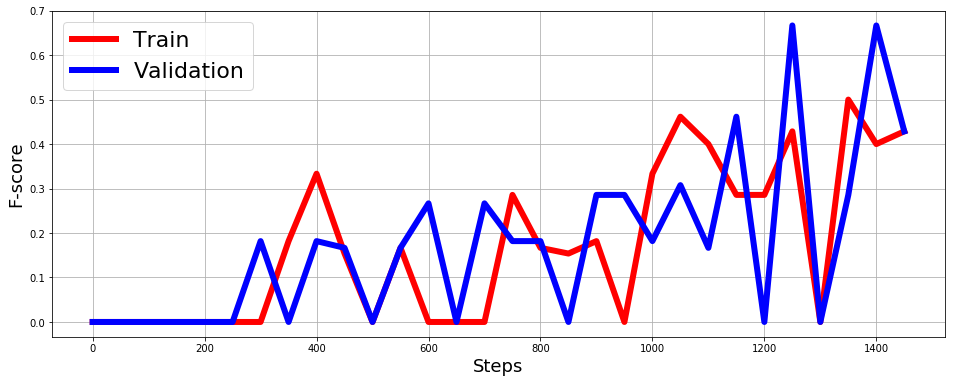

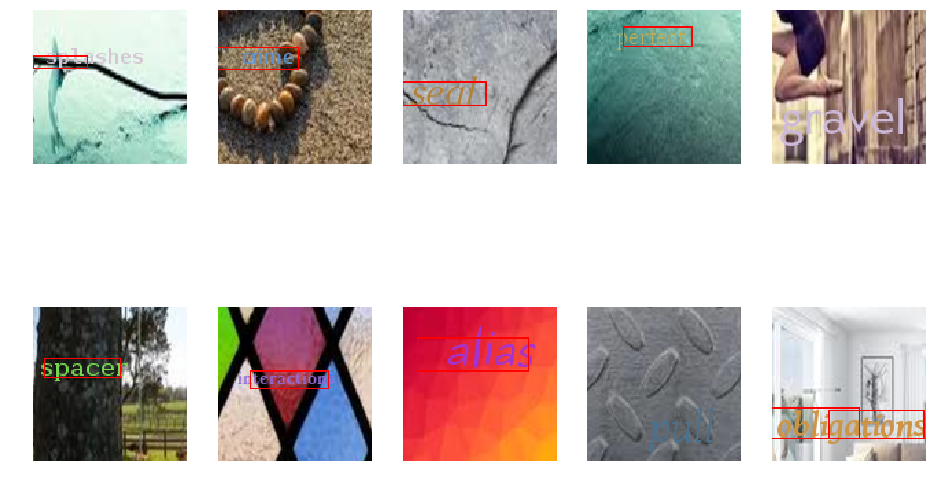

In [15]:
# Train deep network.
def fun_train_test_network(batch_size, num_train_steps):
    ''' This function trains and tests the deep network for text detection. '''
    
    # gpu configuration.
    config = fun_gpu_configuration()

    #==============================================================================
    # Graph Computation 
    #==============================================================================
    
    # Tensorflow graph.
    graph = tf.Graph()
    with graph.as_default():
    
        # Placeholders for input image and ground truth.
        x_image, y_mask, keep_prob, train_phase = fun_placeholders(batch_size)
        
        # Network output.
        prediction = fun_network(x_image, keep_prob, train_phase)
        
        # Mean-squared error loss.
        loss = fun_mean_squared_error_loss(prediction, y_mask, batch_size)

        # Optimizer.
        optimizer = fun_optimizer(loss)

    #==============================================================================
    # Tensorflow Session 
    #==============================================================================
    
    # Session.
    with tf.Session(config=config, graph=graph) as sess:

        # Initialize variables.
        sess.run(tf.global_variables_initializer())
       
        #==========================================================================
        # Training
        #==========================================================================
   
        # Message.
        print('Training:')
        print('  [Step] [Train|Validation loss] [Train|Validation F-score]')
   
        # Variables.
        train_loss_vec = []  # Training loss.
        valid_loss_vec = []  # Validation loss.
        train_accu_vec = []  # Train accuracy -text detection-.
        valid_accu_vec = []  # Validation accuracy -text detection-.

        # Training iterations.
        for s in range(num_train_steps):

            #======================================================================
            # Network computation.
            #======================================================================
   
            # Mini-batch [training data]
            x_batch, y_batch = fun_next_batch(train_images, train_masks, \
                                              batch_size, s)
           
            # Network computation using the training mini-batch.
            sess.run(optimizer, feed_dict = {x_image:x_batch, y_mask:y_batch, \
                                             keep_prob:0.5, train_phase:True})
            
            #======================================================================
            # Network Performance.
            #======================================================================
            
            # Compute network performance.
            if (s+1) % 50 == 0:
                
                # Prediction and loss for training mini-batch.
                train_pred, train_loss = sess.run([prediction, loss], \
                                              feed_dict = {x_image:x_batch, \
                                                           y_mask:y_batch, \
                                                           keep_prob:1.0, \
                                                           train_phase:False})
                
                # Text detection rates for training mini-batch.
                train_rates = eval.fun_text_detection_accuracy(train_pred, y_batch, \
                                                               cell_size)

                # Mini-batch [validation data].
                x_batch, y_batch = fun_next_batch(valid_images, valid_masks, \
                                                  batch_size, s)
                
                # Prediction and loss for validation mini-batch.
                valid_pred, valid_loss = sess.run([prediction, loss], \
                                                 feed_dict = {x_image:x_batch, \
                                                              y_mask:y_batch, \
                                                              keep_prob:1.0, \
                                                              train_phase:False})
                
                # Text detection rates for validation mini-batch.
                valid_rates = eval.fun_text_detection_accuracy(valid_pred, y_batch, \
                                                              cell_size)
                # Message.
                print('  [Step: {0}/{1}] '.format(s+1, num_train_steps) + \
                      '[Loss: {0:.3f}|{1:.03f}] '.format(train_loss, valid_loss) +
                      '[F-score: {0:.3f}|{1:.3f}] '.format(train_rates[5], \
                                                            valid_rates[5]))
                # Save accuracy and loss.
                train_loss_vec.append(train_loss)
                valid_loss_vec.append(valid_loss)
                train_accu_vec.append(train_rates[5])
                valid_accu_vec.append(valid_rates[5])
                
        #==========================================================================
        # Test
        #==========================================================================
   
        # Message.
        print('Testing:')
        
        # Number of test images.
        num_test_images = test_images.shape[0]
        
        # Testing.
        for s in range(num_test_images/batch_size):
     
            # Mini-batch [test data].
            x_batch, y_batch = fun_next_batch(test_images, test_masks, \
                                              batch_size, s, shuffle=False)
            # Prediction.
            test_pred = sess.run(prediction, feed_dict={x_image:x_batch, \
                                              y_mask:y_batch, \
                                              keep_prob:1.0, \
                                              train_phase:False})
            # Store all predictions.
            if s==0: acc_pred = test_pred
            if s>0: acc_pred = np.vstack((acc_pred, test_pred))
                
        # Text detection rates for test data -all images-.
        test_rates = eval.fun_text_detection_accuracy(acc_pred, test_masks,\
                                                     cell_size)
        # Messages.
        print('  Recall: {0:.3f}'.format(test_rates[3]))
        print('  Precision: {0:.3f}'.format(test_rates[4]))
        print('  F-score: {0:.3f}'.format(test_rates[5]))
        print('  True positives: {0:.0f}'.format(test_rates[0]))
        print('  False positives: {0:.0f}'.format(test_rates[1]))
        print('  False negatives: {0:.0f}'.format(test_rates[2]))
   
        #==========================================================================
        # Visualization
        #==========================================================================
              
        # Plot training and validation loss.    
        fig = plt.figure(figsize=(16, 6))
        x = range(0, num_train_steps, 50)
        plt.plot(x, train_loss_vec, 'r-', linewidth=6, label='Train')
        plt.plot(x, valid_loss_vec, 'b-', linewidth=6, label='Validation')
        plt.legend(fontsize=22)
        plt.grid()
        plt.ylabel('Loss', fontsize=18)
        plt.xlabel('Steps', fontsize=18)
        plt.show()
        
        # Plot training and validation f-score.
        fig = plt.figure(figsize=(16,6))
        plt.plot(x, train_accu_vec, 'r-', linewidth=6, label='Train')
        plt.plot(x, valid_accu_vec, 'b-', linewidth=6, label='Validation')
        plt.legend(fontsize=22)
        plt.grid()
        plt.ylabel('F-score', fontsize=18)
        plt.xlabel('Steps', fontsize=18)
        plt.show()
        
        # Network output: It shows the text detections in the last test mini-batch.
        imgs = 255*(x_batch + 0.5)  # Scale between 0 and 255.
        imgs = eval.fun_draw_text_boxes(imgs, test_pred, cell_size)
        
        # Figure.
        fig = plt.figure(figsize=(16,10))
        for i in range(batch_size):
            ax = fig.add_subplot(2, 5, i+1)
            ax.imshow(np.uint8(imgs[i,:,:,:]))
            ax.axis('off')
        plt.show()

# Train network.
fun_train_test_network(batch_size=10, num_train_steps=1500)
